In [1]:
import pickle

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


In [2]:
import numpy as np
import os

# Directory containing CIFAR-10 batches
data_dir = 'D:\\CSE 440\\cifar-10-batches-py'

# Load all data batches
def load_cifar10_data(data_dir):
    # Initialize empty lists for images and labels
    images = []
    labels = []
    
    # Load each data batch
    for batch_id in range(1, 6):
        batch = unpickle(os.path.join(data_dir, f'data_batch_{batch_id}'))
        images.append(batch[b'data'])
        labels += batch[b'labels']
    
    # Stack the image arrays and reshape to (50000, 32, 32, 3)
    images = np.vstack(images).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    labels = np.array(labels)
    
    # Load the test batch
    test_batch = unpickle(os.path.join(data_dir, 'test_batch'))
    test_images = test_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    test_labels = np.array(test_batch[b'labels'])
    
    return images, labels, test_images, test_labels

train_images, train_labels, test_images, test_labels = load_cifar10_data(data_dir)
print(f"Training images shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

Training images shape: (50000, 32, 32, 3)
Training labels shape: (50000,)
Test images shape: (10000, 32, 32, 3)
Test labels shape: (10000,)


In [3]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL Image
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class CIFAR10CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


In [5]:
# Split into training and validation sets
train_images_split, val_images, train_labels_split, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

# Create dataset instances
train_dataset = CIFAR10CustomDataset(train_images_split, train_labels_split, transform=transform)
val_dataset = CIFAR10CustomDataset(val_images, val_labels, transform=transform)
test_dataset = CIFAR10CustomDataset(test_images, test_labels, transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import timm
import matplotlib.pyplot as plt
import os
import pickle

class CIFAR10CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

train_images_split, val_images, train_labels_split, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42)

train_dataset = CIFAR10CustomDataset(train_images_split, train_labels_split, transform=transform)
val_dataset = CIFAR10CustomDataset(val_images, val_labels, transform=transform)
test_dataset = CIFAR10CustomDataset(test_images, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the Neural Network
class NeuralNet(nn.Module):
    def __init__(self, num_classes=10):
        super(NeuralNet, self).__init__()
        self.model = timm.create_model("efficientvit_b0.r224_in1k", pretrained=True, num_classes=num_classes)
        

    def forward(self, x):
        return self.model(x)

# Genetic Algorithm for Model Optimization
class GeneticAlgorithm:
    def __init__(self, population_size, mutation_rate, generations):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.generations = generations
        self.population = [NeuralNet().to(device) for _ in range(population_size)]
    
    def train_model(self, model, train_loader, criterion, optimizer, scheduler, epochs):
        model.train()
        for epoch in range(epochs):
            running_loss = 0.0
            correct = 0
            total = 0
    
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device).long()
    
                # Zero the parameter gradients
                optimizer.zero_grad()
    
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
    
                # Accumulate loss
                running_loss += loss.item()
    
                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
    
            train_acc = 100 * correct / total
    
            # Calculate average loss for the epoch
            avg_loss = running_loss / len(train_loader)
            
            # Scheduler step with the validation metric
            scheduler.step(avg_loss)  # Use the average training loss as the metric
    
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, Train Acc: {train_acc:.2f}%")
        
        return train_acc


    def evaluate_model(self, model, val_loader):
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).long()
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_acc = 100 * correct / total
        return val_acc

    def mutate(self, model):
        # Mutate the model weights with some noise
        with torch.no_grad():
            for param in model.parameters():
                if torch.rand(1).item() < self.mutation_rate:
                    noise = torch.randn_like(param) * 0.05  # Adjust noise scale as needed
                    param.add_(noise)

    def run_evolution(self):
        criterion = nn.CrossEntropyLoss()
        best_accuracy = 0
        best_model = None

        for generation in range(self.generations):
            print(f"Generation {generation + 1}/{self.generations}")

            accuracies = []
            for idx, model in enumerate(self.population):
                optimizer = optim.Adam(model.parameters(), lr=0.001)
                scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)
                
                train_acc = self.train_model(model, train_loader, criterion, optimizer, scheduler, epochs=5)
                val_acc = self.evaluate_model(model, val_loader)
                accuracies.append(val_acc)
                print(f"Model {idx + 1}: Train Acc = {train_acc:.2f}%, Val Acc = {val_acc:.2f}%")

                # Check if this is the best model so far
                if val_acc > best_accuracy:
                    best_accuracy = val_acc
                    best_model = model

            # Reproduction: Select two best models to reproduce
            sorted_indices = np.argsort(accuracies)[-2:]
            parent1, parent2 = self.population[sorted_indices[0]], self.population[sorted_indices[1]]

            # Generate new population through crossover and mutation
            new_population = []
            for _ in range(self.population_size):
                child = NeuralNet().to(device)
                child.load_state_dict(parent1.state_dict(), strict=False)
                self.mutate(child)
                new_population.append(child)

            self.population = new_population

        # Evaluate the best model on the test set
        test_accuracy = self.evaluate_model(best_model, test_loader)
        print(f"Test Accuracy of the best model: {test_accuracy:.2f}%")
        
        # Return the best model for later use
        return best_model

# Run Genetic Algorithm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GA = GeneticAlgorithm(population_size=8, mutation_rate=0.05, generations=4)
best_model = GA.run_evolution()

Generation 1/4
Epoch [1/5], Loss: 0.6822, Train Acc: 76.47%
Epoch [2/5], Loss: 0.4345, Train Acc: 85.14%
Epoch [3/5], Loss: 0.3464, Train Acc: 87.99%
Epoch [4/5], Loss: 0.2962, Train Acc: 89.69%
Epoch [5/5], Loss: 0.1414, Train Acc: 95.10%
Model 1: Train Acc = 95.10%, Val Acc = 90.33%
Epoch [1/5], Loss: 0.9393, Train Acc: 67.24%
Epoch [2/5], Loss: 0.5251, Train Acc: 82.04%
Epoch [3/5], Loss: 0.4119, Train Acc: 85.77%
Epoch [4/5], Loss: 0.4216, Train Acc: 85.43%
Epoch [5/5], Loss: 0.1997, Train Acc: 93.02%
Model 2: Train Acc = 93.02%, Val Acc = 89.24%
Epoch [1/5], Loss: 0.6838, Train Acc: 76.33%
Epoch [2/5], Loss: 0.4291, Train Acc: 85.51%
Epoch [3/5], Loss: 0.3478, Train Acc: 88.14%
Epoch [4/5], Loss: 0.3001, Train Acc: 89.43%
Epoch [5/5], Loss: 0.1504, Train Acc: 94.78%
Model 3: Train Acc = 94.78%, Val Acc = 90.47%
Epoch [1/5], Loss: 0.7747, Train Acc: 73.35%
Epoch [2/5], Loss: 0.4544, Train Acc: 84.35%
Epoch [3/5], Loss: 0.3628, Train Acc: 87.45%
Epoch [4/5], Loss: 0.3140, Train Acc:

In [4]:
meta = unpickle(os.path.join(data_dir, 'batches.meta'))
label_names = meta[b'label_names']
label_names = [name.decode('utf-8') for name in label_names]
print("Label names:", label_names)

Label names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [6]:
import torch.nn as nn
import torch.optim as optim
import timm

# Number of classes
num_classes = 10  # Change this based on your use case if necessary

# Load model
model = timm.create_model("efficientvit_b0.r224_in1k", pretrained=True, num_classes=num_classes)

# Freeze all layers except the head
for param in model.parameters():
    param.requires_grad = False
for param in model.head.parameters():
    param.requires_grad = True

# Move model to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.head.parameters(), lr=0.01)

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from torchinfo import summary
summary(model = model, 
        input_size=(10, 3, 32, 32),  
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=15,
        row_settings=["var_names"])

Layer (type (var_name))                                           Input Shape     Output Shape    Param #         Trainable
EfficientVit (EfficientVit)                                       [10, 3, 32, 32] [10, 10]        --              Partial
├─Stem (stem)                                                     [10, 3, 32, 32] [10, 8, 16, 16] --              False
│    └─ConvNormAct (in_conv)                                      [10, 3, 32, 32] [10, 8, 16, 16] --              False
│    │    └─Dropout (dropout)                                     [10, 3, 32, 32] [10, 3, 32, 32] --              --
│    │    └─Conv2d (conv)                                         [10, 3, 32, 32] [10, 8, 16, 16] (216)           False
│    │    └─BatchNorm2d (norm)                                    [10, 8, 16, 16] [10, 8, 16, 16] (16)            False
│    │    └─Hardswish (act)                                       [10, 8, 16, 16] [10, 8, 16, 16] --              --
│    └─ResidualBlock (res0)             

In [8]:
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='D:\\CSE 440\\Models\\Checkpoint\\model_checkpoint_cifar.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_accuracy_max = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_accuracy, model):
        score = val_accuracy

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_accuracy, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_accuracy, model)
            self.counter = 0

    def save_checkpoint(self, val_accuracy, model):
        '''Saves model when validation accuracy increases.'''
        if self.verbose:
            print(f'Validation accuracy increased ({self.val_accuracy_max:.6f} --> {val_accuracy:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_accuracy_max = val_accuracy


In [10]:
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_model_with_early_stopping(model, train_loader, val_loader, optimizer, loss_fn, epochs, device, patience=5):
    # Initialize early stopping and learning rate scheduler
    early_stopping = EarlyStopping(patience=patience, verbose=True, path='D:\\CSE 440\\Models\\Checkpoint\\model_checkpoint_cifar.pt')
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True, factor=0.1)

    # Lists to store the loss and accuracy values for each epoch
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device).long()
            optimizer.zero_grad()
            outputs = model(data)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == targets).sum().item()

        train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = correct_train / len(train_loader.dataset)

        # Store training metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct_val = 0
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device).long()
                outputs = model(data)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item() * data.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == targets).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = correct_val / len(val_loader.dataset)

        # Store validation metrics
        valid_losses.append(val_loss)
        valid_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{epochs}, Train Accuracy: {train_accuracy:.4f}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

        # Step the scheduler
        scheduler.step(val_loss)

        # Check early stopping based on validation accuracy
        early_stopping(val_accuracy, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Load the best model
    model.load_state_dict(torch.load('D:\\CSE 440\\Models\\Checkpoint\\model_checkpoint_cifar.pt'))

    # Return the model and collected metrics
    return model, train_losses, valid_losses, train_accuracies, valid_accuracies

# Training the model with the modified function
model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model_with_early_stopping(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_fn=criterion,
    epochs=100,
    device=device,
    patience=10  # Early stopping patience
)

C:\Users\User\anaconda3\envs\torch\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Train Accuracy: 0.8044, Train Loss: 0.5915, Validation Loss: 0.4342, Validation Accuracy: 0.8567
Validation accuracy increased (inf --> 0.856700).  Saving model ...
Epoch 2/100, Train Accuracy: 0.8702, Train Loss: 0.3773, Validation Loss: 0.3469, Validation Accuracy: 0.8830
Validation accuracy increased (0.856700 --> 0.883000).  Saving model ...
Epoch 3/100, Train Accuracy: 0.8944, Train Loss: 0.3079, Validation Loss: 0.3505, Validation Accuracy: 0.8835
Validation accuracy increased (0.883000 --> 0.883500).  Saving model ...
Epoch 4/100, Train Accuracy: 0.9133, Train Loss: 0.2475, Validation Loss: 0.3467, Validation Accuracy: 0.8881
Validation accuracy increased (0.883500 --> 0.888100).  Saving model ...
Epoch 5/100, Train Accuracy: 0.9286, Train Loss: 0.2064, Validation Loss: 0.3719, Validation Accuracy: 0.8868
EarlyStopping counter: 1 out of 10
Epoch 6/100, Train Accuracy: 0.9421, Train Loss: 0.1673, Validation Loss: 0.4253, Validation Accuracy: 0.8840
EarlyStopping coun

C:\Users\User\AppData\Local\Temp\ipykernel_25404\3598464788.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('D:\\CSE 440\\Models\\Check

Adam

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
def test_model(model, dataloader):
    model.eval()
    test_loss = 0.0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device).long()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    test_loss /= len(dataloader.dataset)
    
    return test_loss, true_labels, predictions

# Testing the model
test_loss, true_labels, predictions = test_model(model, test_loader)
print(f'Test Loss: {test_loss:.4f}')

# Classification Report
print('Classification Report:')
print(classification_report(true_labels, predictions, digits=4, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
print('Confusion Matrix:')
print(cm)


Test Loss: 0.6188
Classification Report:
              precision    recall  f1-score   support

    airplane     0.9025    0.8980    0.9003      1000
  automobile     0.9503    0.9560    0.9531      1000
        bird     0.9032    0.8770    0.8899      1000
         cat     0.8052    0.8100    0.8076      1000
        deer     0.8886    0.8850    0.8868      1000
         dog     0.8495    0.8410    0.8452      1000
        frog     0.9217    0.9540    0.9376      1000
       horse     0.9400    0.9240    0.9319      1000
        ship     0.9254    0.9310    0.9282      1000
       truck     0.9298    0.9410    0.9354      1000

    accuracy                         0.9017     10000
   macro avg     0.9016    0.9017    0.9016     10000
weighted avg     0.9016    0.9017    0.9016     10000

Confusion Matrix:
[[898   1  21   8   4   2   4   2  39  21]
 [  6 956   1   0   0   1   2   0   6  28]
 [ 17   1 877  23  23  21  24   7   6   1]
 [  6   2  18 810  29  85  25  15   8   2]
 [  6   2 

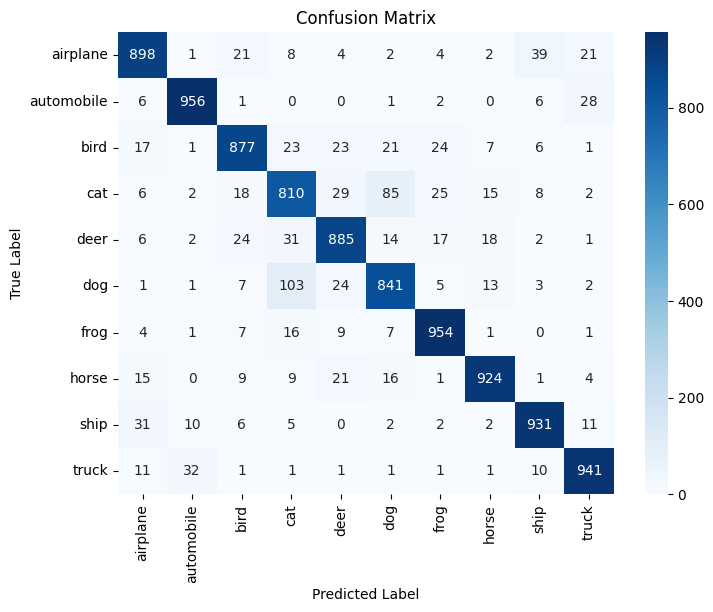

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt=".0f", xticklabels = class_names, yticklabels = class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

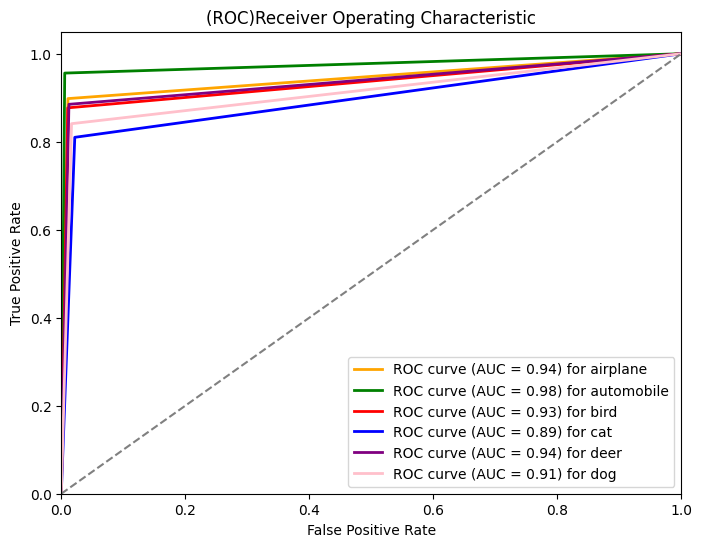

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
fpr = dict()
tpr = dict()
roc_auc = dict()

n_class = 6

for i in range(n_class):
    fpr[i], tpr[i], _ = roc_curve(np.array(true_labels) == i, np.array(predictions) == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['orange', 'green', 'red', 'blue', 'purple', 'pink']

for i in range(n_class):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve (AUC = {roc_auc[i]:.2f}) for {class_names[i]}')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC)Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

<h1>GA with Adam</h1>

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
criterion = nn.CrossEntropyLoss()

def test_model(model, dataloader):
    model.eval()
    test_loss = 0.0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device).long()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    test_loss /= len(dataloader.dataset)
    
    return test_loss, true_labels, predictions

# Testing the model
test_loss, true_labels, predictions = test_model(best_model, test_loader)
print(f'Test Loss: {test_loss:.4f}')

# Classification Report
print('Classification Report:')
print(classification_report(true_labels, predictions, digits=4, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
print('Confusion Matrix:')
print(cm)


Test Loss: 0.3212
Classification Report:
              precision    recall  f1-score   support

    airplane     0.9405    0.9160    0.9281      1000
  automobile     0.9486    0.9780    0.9631      1000
        bird     0.9095    0.9150    0.9123      1000
         cat     0.8312    0.8420    0.8366      1000
        deer     0.9362    0.9240    0.9300      1000
         dog     0.8885    0.8370    0.8620      1000
        frog     0.9112    0.9640    0.9368      1000
       horse     0.9550    0.9560    0.9555      1000
        ship     0.9415    0.9490    0.9452      1000
       truck     0.9602    0.9410    0.9505      1000

    accuracy                         0.9222     10000
   macro avg     0.9222    0.9222    0.9220     10000
weighted avg     0.9222    0.9222    0.9220     10000

Confusion Matrix:
[[916   4  15   6   5   4   7   1  29  13]
 [  1 978   1   1   0   1   1   0   5  12]
 [ 13   0 915  17  18  10  19   4   4   0]
 [  7   2  26 842  13  63  32   7   7   1]
 [  3   1 

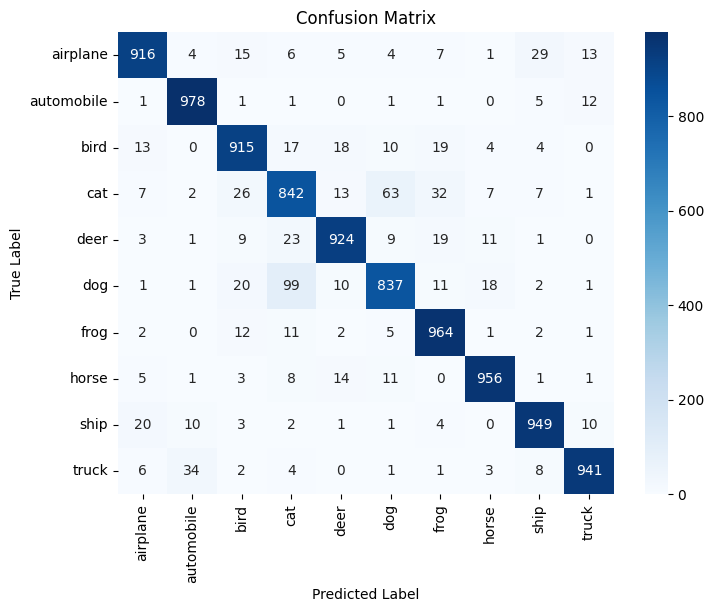

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt=".0f", xticklabels = class_names, yticklabels = class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

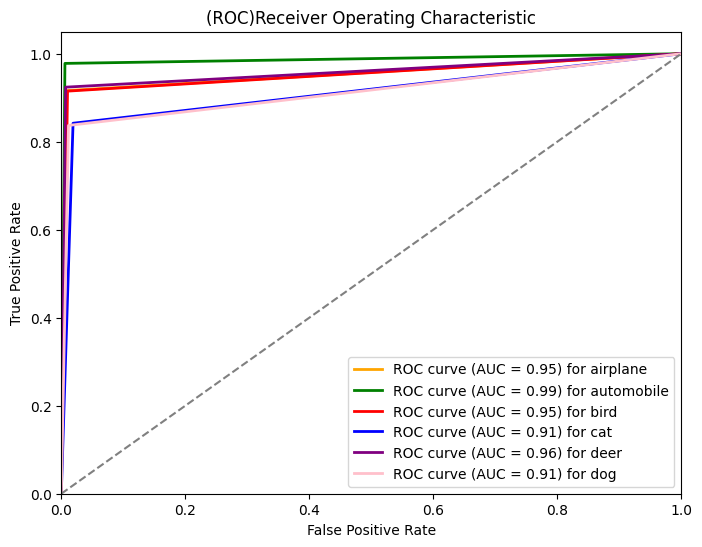

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
fpr = dict()
tpr = dict()
roc_auc = dict()

n_class = 6

for i in range(n_class):
    fpr[i], tpr[i], _ = roc_curve(np.array(true_labels) == i, np.array(predictions) == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['orange', 'green', 'red', 'blue', 'purple', 'pink']

for i in range(n_class):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve (AUC = {roc_auc[i]:.2f}) for {class_names[i]}')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC)Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

SGD

In [10]:
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
def train_model_with_early_stopping(model, train_loader, val_loader, optimizer, loss_fn, epochs, device, patience=5):
    # Initialize early stopping and learning rate scheduler
    early_stopping = EarlyStopping(patience=patience, verbose=True, path='D:\\CSE 440\\Models\\Checkpoint\\model_checkpoint_cifar.pt')
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True, factor=0.1)

    # Lists to store the loss and accuracy values for each epoch
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device).long()
            optimizer.zero_grad()
            outputs = model(data)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == targets).sum().item()

        train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = correct_train / len(train_loader.dataset)

        # Store training metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct_val = 0
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device).long()
                outputs = model(data)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item() * data.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == targets).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = correct_val / len(val_loader.dataset)

        # Store validation metrics
        valid_losses.append(val_loss)
        valid_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{epochs}, Train Accuracy: {train_accuracy:.4f}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

        # Step the scheduler
        scheduler.step(val_loss)

        # Check early stopping based on validation accuracy
        early_stopping(val_accuracy, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Load the best model
    model.load_state_dict(torch.load('D:\\CSE 440\\Models\\Checkpoint\\model_checkpoint_cifar.pt'))

    # Return the model and collected metrics
    return model, train_losses, valid_losses, train_accuracies, valid_accuracies

# Training the model with the modified function
model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model_with_early_stopping(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_fn=criterion,
    epochs=100,
    device=device,
    patience=10  # Early stopping patience
)

C:\Users\User\anaconda3\envs\torch\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Train Accuracy: 0.8361, Train Loss: 0.4889, Validation Loss: 0.3362, Validation Accuracy: 0.8826
Validation accuracy increased (inf --> 0.882600).  Saving model ...
Epoch 2/100, Train Accuracy: 0.9126, Train Loss: 0.2496, Validation Loss: 0.3274, Validation Accuracy: 0.8925
Validation accuracy increased (0.882600 --> 0.892500).  Saving model ...
Epoch 3/100, Train Accuracy: 0.9414, Train Loss: 0.1658, Validation Loss: 0.3551, Validation Accuracy: 0.8878
EarlyStopping counter: 1 out of 10
Epoch 4/100, Train Accuracy: 0.9604, Train Loss: 0.1104, Validation Loss: 0.3758, Validation Accuracy: 0.8939
Validation accuracy increased (0.892500 --> 0.893900).  Saving model ...
Epoch 5/100, Train Accuracy: 0.9715, Train Loss: 0.0828, Validation Loss: 0.4334, Validation Accuracy: 0.8873
EarlyStopping counter: 1 out of 10
Epoch 6/100, Train Accuracy: 0.9761, Train Loss: 0.0672, Validation Loss: 0.4262, Validation Accuracy: 0.8967
Validation accuracy increased (0.893900 --> 0.896700).  

C:\Users\User\AppData\Local\Temp\ipykernel_12708\3719178817.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('D:\\CSE 440\\Models\\Check

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
criterion = nn.CrossEntropyLoss()

def test_model(model, dataloader):
    model.eval()
    test_loss = 0.0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device).long()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    test_loss /= len(dataloader.dataset)
    
    return test_loss, true_labels, predictions

# Testing the model
test_loss, true_labels, predictions = test_model(model, test_loader)
print(f'Test Loss: {test_loss:.4f}')

# Classification Report
print('Classification Report:')
print(classification_report(true_labels, predictions, digits=4, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
print('Confusion Matrix:')
print(cm)


Test Loss: 0.4431
Classification Report:
              precision    recall  f1-score   support

    airplane     0.9157    0.9230    0.9193      1000
  automobile     0.9522    0.9560    0.9541      1000
        bird     0.8965    0.8750    0.8856      1000
         cat     0.8203    0.7990    0.8095      1000
        deer     0.8848    0.8990    0.8919      1000
         dog     0.8534    0.8560    0.8547      1000
        frog     0.9030    0.9400    0.9211      1000
       horse     0.9391    0.9250    0.9320      1000
        ship     0.9453    0.9340    0.9396      1000
       truck     0.9463    0.9510    0.9486      1000

    accuracy                         0.9058     10000
   macro avg     0.9057    0.9058    0.9057     10000
weighted avg     0.9057    0.9058    0.9057     10000

Confusion Matrix:
[[923   3  19   6   3   0   5   5  23  13]
 [  5 956   0   2   1   0   3   0   8  25]
 [ 18   0 875  23  27  19  29   5   4   0]
 [  9   2  22 799  23  94  35   9   4   3]
 [  9   2 

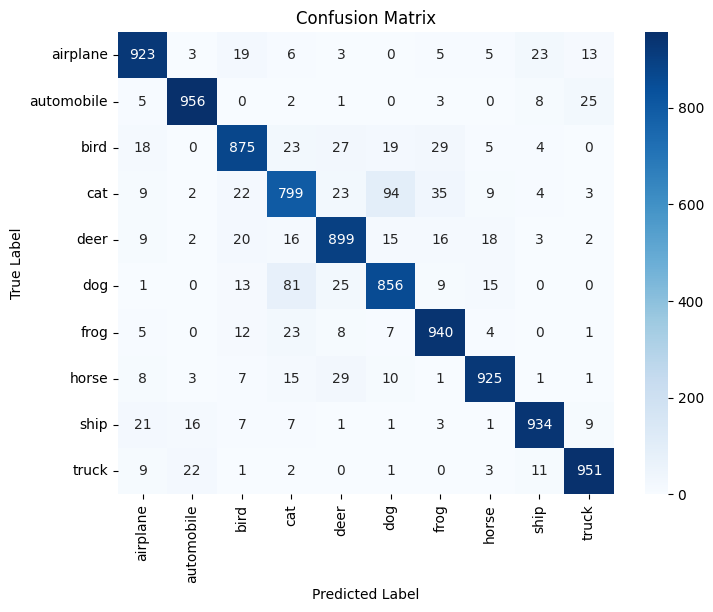

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt=".0f", xticklabels = class_names, yticklabels = class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

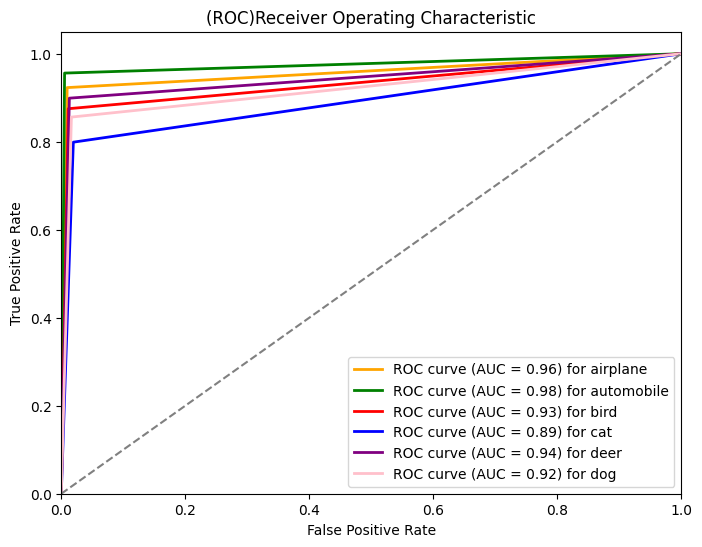

In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
fpr = dict()
tpr = dict()
roc_auc = dict()

n_class = 6

for i in range(n_class):
    fpr[i], tpr[i], _ = roc_curve(np.array(true_labels) == i, np.array(predictions) == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['orange', 'green', 'red', 'blue', 'purple', 'pink']

for i in range(n_class):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve (AUC = {roc_auc[i]:.2f}) for {class_names[i]}')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC)Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [9]:
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = optim.RMSprop(model.parameters(), lr=0.01)
def train_model_with_early_stopping(model, train_loader, val_loader, optimizer, loss_fn, epochs, device, patience=5):
    # Initialize early stopping and learning rate scheduler
    early_stopping = EarlyStopping(patience=patience, verbose=True, path='D:\\CSE 440\\Models\\Checkpoint\\model_checkpoint_cifar.pt')
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True, factor=0.1)

    # Lists to store the loss and accuracy values for each epoch
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device).long()
            optimizer.zero_grad()
            outputs = model(data)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == targets).sum().item()

        train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = correct_train / len(train_loader.dataset)

        # Store training metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct_val = 0
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device).long()
                outputs = model(data)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item() * data.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == targets).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = correct_val / len(val_loader.dataset)

        # Store validation metrics
        valid_losses.append(val_loss)
        valid_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{epochs}, Train Accuracy: {train_accuracy:.4f}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

        # Step the scheduler
        scheduler.step(val_loss)

        # Check early stopping based on validation accuracy
        early_stopping(val_accuracy, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Load the best model
    model.load_state_dict(torch.load('D:\\CSE 440\\Models\\Checkpoint\\model_checkpoint_cifar.pt'))

    # Return the model and collected metrics
    return model, train_losses, valid_losses, train_accuracies, valid_accuracies

# Training the model with the modified function
model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model_with_early_stopping(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_fn=criterion,
    epochs=100,
    device=device,
    patience=10  # Early stopping patience
)

C:\Users\User\anaconda3\envs\torch\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Train Accuracy: 0.7854, Train Loss: 0.8551, Validation Loss: 0.4394, Validation Accuracy: 0.8505
Validation accuracy increased (inf --> 0.850500).  Saving model ...
Epoch 2/100, Train Accuracy: 0.8641, Train Loss: 0.3986, Validation Loss: 0.4150, Validation Accuracy: 0.8629
Validation accuracy increased (0.850500 --> 0.862900).  Saving model ...
Epoch 3/100, Train Accuracy: 0.8995, Train Loss: 0.2967, Validation Loss: 0.3271, Validation Accuracy: 0.8882
Validation accuracy increased (0.862900 --> 0.888200).  Saving model ...
Epoch 4/100, Train Accuracy: 0.9189, Train Loss: 0.2315, Validation Loss: 0.3750, Validation Accuracy: 0.8820
EarlyStopping counter: 1 out of 10
Epoch 5/100, Train Accuracy: 0.9349, Train Loss: 0.1870, Validation Loss: 0.3978, Validation Accuracy: 0.8849
EarlyStopping counter: 2 out of 10
Epoch 6/100, Train Accuracy: 0.9477, Train Loss: 0.1512, Validation Loss: 0.4266, Validation Accuracy: 0.8851
EarlyStopping counter: 3 out of 10
Epoch 7/100, Train Ac

C:\Users\User\AppData\Local\Temp\ipykernel_21604\3451618549.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('D:\\CSE 440\\Models\\Check

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
criterion = nn.CrossEntropyLoss()

def test_model(model, dataloader):
    model.eval()
    test_loss = 0.0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device).long()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    test_loss /= len(dataloader.dataset)
    
    return test_loss, true_labels, predictions

# Testing the model
test_loss, true_labels, predictions = test_model(model, test_loader)
print(f'Test Loss: {test_loss:.4f}')

# Classification Report
print('Classification Report:')
print(classification_report(true_labels, predictions, digits=4, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
print('Confusion Matrix:')
print(cm)


Test Loss: 0.6804
Classification Report:
              precision    recall  f1-score   support

    airplane     0.9025    0.9070    0.9047      1000
  automobile     0.9370    0.9520    0.9444      1000
        bird     0.9036    0.8900    0.8967      1000
         cat     0.8209    0.7790    0.7994      1000
        deer     0.8836    0.9030    0.8932      1000
         dog     0.8429    0.8530    0.8479      1000
        frog     0.9281    0.9420    0.9350      1000
       horse     0.9489    0.9290    0.9389      1000
        ship     0.9333    0.9380    0.9357      1000
       truck     0.9377    0.9490    0.9433      1000

    accuracy                         0.9042     10000
   macro avg     0.9038    0.9042    0.9039     10000
weighted avg     0.9038    0.9042    0.9039     10000

Confusion Matrix:
[[907   5  18   9   6   1   3   6  29  16]
 [ 10 952   0   2   0   0   1   0   9  26]
 [ 16   3 890  24  25  15  19   4   4   0]
 [ 12   7  16 779  31 101  26  12   9   7]
 [  6   3 

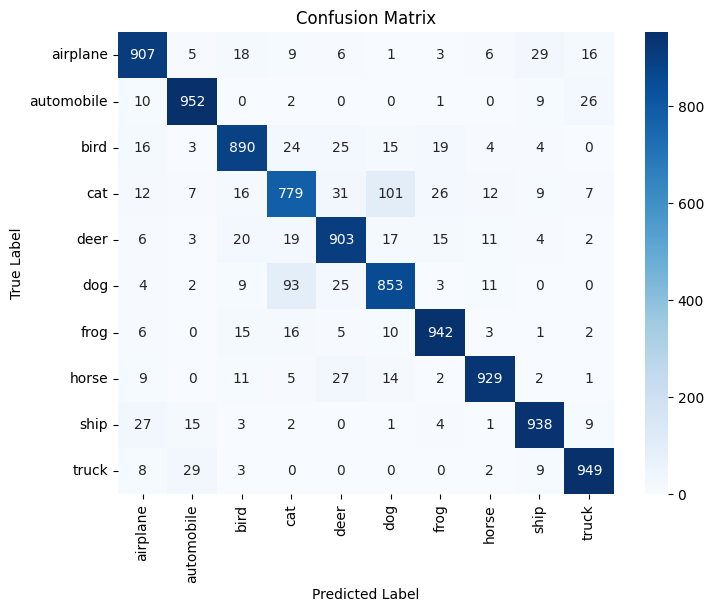

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt=".0f", xticklabels = class_names, yticklabels = class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

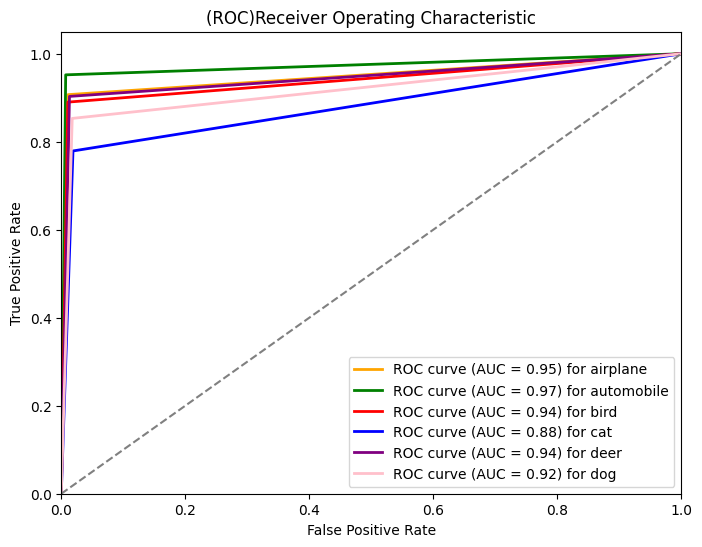

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
fpr = dict()
tpr = dict()
roc_auc = dict()

n_class = 6

for i in range(n_class):
    fpr[i], tpr[i], _ = roc_curve(np.array(true_labels) == i, np.array(predictions) == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['orange', 'green', 'red', 'blue', 'purple', 'pink']

for i in range(n_class):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve (AUC = {roc_auc[i]:.2f}) for {class_names[i]}')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC)Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()